## Steps

All steps that are played by default are **preprocessing** steps, but you can also add **postprocessing** steps, that act on the results instead of the circuit.

The steps will be filtered according to their type automatically.

## Available Processing Steps

### Pre-processing
- **CliffordTDecomposition** (pennylane_calculquebec/processing/steps/base_decomposition.py)  
  Decomposes gates into the Clifford+T+RZ set.  
  Parameters: None.
  
- **DecomposeReadout** (pennylane_calculquebec/processing/steps/decompose_readout.py)  
  Converts observables into computational basis measurements.  
  Parameters: None.

- **GateNoiseSimulation** (pennylane_calculquebec/processing/steps/gate_noise_simulation.py)  
  Injects gate noise according to the MonarQ model.  
  Parameters: `machine_name`, `use_benchmark`.


- **MonarqDecomposition** (pennylane_calculquebec/processing/steps/native_decomposition.py)  
  Converts operations to MonarQ native gates.  
  Parameters: None.

- **IterativeCommuteAndMerge** (pennylane_calculquebec/processing/steps/optimization.py)  
  Optimizes the circuit by commuting, merging rotations, and cancellations.  
  Parameters: None.

- **ASTAR**, **ISMAGS**, **VF2** (pennylane_calculquebec/processing/steps/placement.py)  
  Placement algorithms to map logical qubits onto physical qubits.  
  Parameters: `machine_name`, `use_benchmark`, `q1_acceptance`, `q2_acceptance`, `excluded_qubits`, `excluded_couplers`.

- **Swaps** (pennylane_calculquebec/processing/steps/routing.py)  
  Routing algorithm that inserts SWAPs to connect non-adjacent qubits.  
  Parameters: `machine_name`, `use_benchmark`, `q1_acceptance`, `q2_acceptance`, `excluded_qubits`, `excluded_couplers`.

- **PrintTape**, **PrintWires** (pennylane_calculquebec/processing/steps/print_steps.py)  
  Debug steps that print the circuit or wires.  
  Parameters: None.

### Post-processing
- **IBUReadoutMitigation** (pennylane_calculquebec/processing/steps/readout_error_mitigation.py)  
  Iterative Bayesian readout error mitigation.  
  Parameters: `machine_name`, `initial_guess`.

- **MatrixReadoutMitigation** (pennylane_calculquebec/processing/steps/readout_error_mitigation.py)  
  Matrix inversion readout error mitigation.  
  Parameters: `machine_name`.

- **ReadoutNoiseSimulation** (pennylane_calculquebec/processing/steps/readout_noise_simulation.py)  
  Simulates readout noise on the results.  
  Parameters: `machine_name`, `use_benchmark`.

- **PrintResults** (pennylane_calculquebec/processing/steps/print_steps.py)  
  Debug step that prints the results.  
  Parameters: None.

## Example of code for the preprocessing for the CliffordTDecomposition

Note: you may need to restart the kernel to use updated packages.
0: ──T──RZ─┤  <Z>


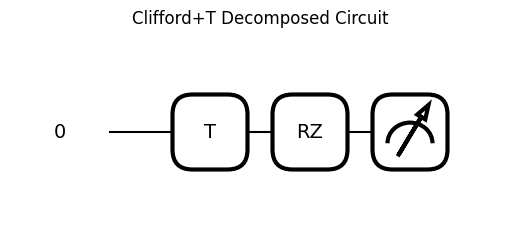

In [3]:
%pip install matplotlib
import pennylane as qml
from pennylane.workflow import construct_tape
from pennylane.drawer import tape_text, tape_mpl
from pennylane_calculquebec.processing.steps import CliffordTDecomposition

# 1. define device & QNode
dev = qml.device("default.qubit", wires=1)


@qml.qnode(dev)
def circuit():
    qml.T(wires=0)
    qml.RZ(0.5, wires=0)
    return qml.expval(qml.PauliZ(0))


# 2. build raw tape (user ops only)
tape = construct_tape(circuit, level="top")()

# 3. apply your CalculQuébec decomposition
step = CliffordTDecomposition()
decomposed = step.execute(tape)

# 4a. text drawing
print(tape_text(decomposed, show_wire_labels=True))

# 4b. matplotlib drawing
fig, ax = tape_mpl(decomposed)
ax.set_title("Clifford+T Decomposed Circuit")
fig.savefig("decomposed_circuit.png")  # or plt.show()

### Example of code for the preprocessing for the DecomposeReadout

In [4]:
import pennylane as qml
from pennylane.workflow import construct_tape
from pennylane_calculquebec.processing.steps import DecomposeReadout

# Build a circuit returning an observable
dev = qml.device("default.qubit", wires=1)


@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    return qml.expval(qml.PauliZ(wires=0))


# Construct the tape for the QNode
tape = construct_tape(circuit)()

# Apply DecomposeReadout to convert expectation to computational basis measurement
step = DecomposeReadout()
post = step.execute(tape)

# Inspect the measurement operators on the new tape
print(post.measurements)

[expval(wires=[0])]


###  Example of code for the preprocessing for the DecomposeReadout

In [5]:
from pennylane_calculquebec.processing.config import MonarqDefaultConfig
from pennylane_calculquebec.processing.steps import IBUReadoutMitigation

readout_error_mitigation = IBUReadoutMitigation("yamaska")

my_config = MonarqDefaultConfig("yamaska")
my_config.steps.append(readout_error_mitigation)
print(*my_config.steps, sep="\n")

### Example of code for the preprocessing for the GateNoiseSimulation

In [15]:
import pennylane as qml
from pennylane.workflow import construct_tape
from pennylane_calculquebec.processing.steps import GateNoiseSimulation

# 1) Define your device
dev = qml.device("default.qubit", wires=1)


# 2) Define your noiseless circuit as a QNode
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    return qml.probs(wires=0)


# 3) Turn that QNode into a tape
tape = construct_tape(circuit)()

# 4) Inject noise using your Yamaska profile
noise_step = GateNoiseSimulation("yamaska", use_benchmark=True)
noisy_tape = noise_step.execute(tape)

# 5) Execute the noisy tape directly on the device
noisy_results = qml.execute([noisy_tape], dev)

print("Noisy probabilities:", noisy_results[0])

Noisy probabilities: [0.5 0.5]


### Example of code for the preprocessing for the MonarqDecomposition

In [7]:
import pennylane as qml
from pennylane_calculquebec.processing.steps import MonarqDecomposition
from pennylane.workflow import construct_tape
from pennylane.drawer import tape_text

# Circuit using non-native ops
dev = qml.device("default.qubit", wires=2)


@qml.qnode(dev)
def circuit():
    qml.SWAP(wires=[0, 1])  # placeholder non-native
    return qml.expval(qml.PauliZ(0))


# Convert to MonarQ native gates
step = MonarqDecomposition()
native = step.execute(construct_tape(circuit)())
print(tape_text(native))  # only MonarQ primitive gates

1: ──Z90──X90──Z90─╭Z──Z90──X90──Z90─╭●──Z90──X90──Z90─╭Z──Z90──X90──Z90─┤     
0: ────────────────╰●──Z90──X90──Z90─╰Z──Z90──X90──Z90─╰●────────────────┤  <Z>


### Example of code for the preprocessing for the IterativeCommuteAndMerge

In [8]:
import pennylane as qml
from pennylane.workflow import construct_tape
from pennylane_calculquebec.processing.steps import IterativeCommuteAndMerge
from pennylane.drawer import tape_text

# Circuit with redundant rotations
dev = qml.device("default.qubit", wires=1)


@qml.qnode(dev)
def circuit():
    qml.RX(0.5, wires=0)
    qml.RX(-0.5, wires=0)  # cancelling rotation
    return qml.expval(qml.PauliX(0))


# Optimize by merging and cancelling
step = IterativeCommuteAndMerge()
optimized = step.execute(construct_tape(circuit)())
print(tape_text(optimized))  # empty or minimal operations

0: ───┤  <X>


### Example of code for the preprocessing for the ASTAR

In [9]:
import pennylane as qml
from pennylane.workflow import construct_tape
from pennylane_calculquebec.processing.steps import ASTAR
from pennylane.drawer import tape_text  # for visualization

# 1. Create a 2-qubit device
dev = qml.device("default.qubit", wires=2)


# 2. Build a 2-qubit QNode (with a CNOT gate)
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0))


# 3. Extract the tape (QuantumScript) from the QNode
tape = construct_tape(circuit)()

# 4. Apply ASTAR placement algorithm
step = ASTAR("yamaska", use_benchmark=False)
mapped = step.execute(tape)

# 5. Print the remapped operations
print("Mapped circuit on Yamaska topology:")
print(tape_text(mapped))  # Pretty-prints QuantumScript

Mapped circuit on Yamaska topology:
4: ──H─╭●─┤  <Z>
0: ────╰X─┤     


### Example of code for the preprocessing for the Swaps

In [10]:
import pennylane as qml
from pennylane.workflow import construct_tape
from pennylane.drawer import tape_text  # pretty-print tapes
from pennylane_calculquebec.processing.steps import Swaps

# ------------------------------------------------------------------
# 1) Build a tiny circuit whose 2-qubit gate is *not* adjacent on
#    Yamaska.  We'll assume Yamaska qubits are numbered 0..59
#    and that 0 and 5 are *not* directly connected.
# ------------------------------------------------------------------
dev = qml.device("default.qubit", wires=6)  # at least wires 0–5


@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 5])  # <-- distant pair
    return qml.expval(qml.PauliZ(0))


tape = construct_tape(circuit)()  # QuantumScript

print("Original circuit:")
print(tape_text(tape), "\n")

# ------------------------------------------------------------------
# 2) Route with the Swaps algorithm
# ------------------------------------------------------------------
router = Swaps("yamaska", use_benchmark=False)
mapped = router.execute(tape)

print("After routing with SWAPs:")
print(tape_text(mapped))

Original circuit:
0: ──H─╭●─┤  <Z>
5: ────╰X─┤      

After routing with SWAPs:
0: ──H──────────╭●─────────────┤  <Z>
1: ─╭SWAP─╭SWAP─│──╭SWAP─╭SWAP─┤     
5: ─╰SWAP─│─────│──│─────╰SWAP─┤     
4: ───────╰SWAP─╰X─╰SWAP───────┤     


### Example of code for the preprocessing for the PrintTape

In [11]:
import pennylane as qml
from pennylane.workflow import construct_tape
from pennylane_calculquebec.processing.steps import PrintTape, PrintWires, PrintResults

# 1. Create a device with shots enabled
dev = qml.device("default.qubit", wires=2)


# 2. Define a circuit
@qml.set_shots(10)
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.sample(qml.PauliZ(0))  # sample returns +1/-1


# 3. Extract the tape
tape = construct_tape(circuit)()

# 4. Initialize steps
print_tape = PrintTape()
print_wires = PrintWires()
print_results = PrintResults()

# 5. Run preproc steps
print("\n--- PrintTape ---")
print_tape.execute(tape)

print("\n--- PrintWires ---")
print_wires.execute(tape)

# 6. Execute the tape
results = qml.execute([tape], dev)[0]

# 7. Format results as counts
import collections

counts = dict(collections.Counter(results.tolist()))

print("\n--- PrintResults ---")
print_results.execute(tape, counts)


--- PrintTape ---
H(0) CNOT(wires=[0, 1])

--- PrintWires ---
0 1

--- PrintResults ---
{1.0: 5, -1.0: 5}


{1.0: 5, -1.0: 5}

You can create new preprocessing / postprocessing steps by overriding the PreProcessing / PostProcessing classes.

In [ ]:
# abstract steps + empty config
from pennylane_calculquebec.processing.interfaces import PreProcStep, PostProcStep
from pennylane_calculquebec.processing.config import ProcessingConfig

# default steps
from pennylane_calculquebec.processing.steps import (
    CliffordTDecomposition,
    ASTAR,
    Swaps,
    IterativeCommuteAndMerge,
    MonarqDecomposition,
)

In [ ]:
# toy preprocessing step for printing the circuit operations
class PrintCircuit(PreProcStep):
    def execute(self, tape):
        print(*tape.operations)
        return tape


# toy postprocessing step for printing the results
class PrintResults(PostProcStep):
    def execute(self, tape, results):
        print(results)
        return results

In [ ]:
# this custom config will print the circuit, transpile, print the transpiled circuit
# and then print the unmitigated results, followed by the mitigated results.
my_config = ProcessingConfig(
    PrintCircuit(),
    CliffordTDecomposition(),
    ASTAR("yamaska"),
    Swaps("yamaska"),
    IterativeCommuteAndMerge(),
    MonarqDecomposition(),
    PrintCircuit(),
    PrintResults(),
    IBUReadoutMitigation("yamaska"),
    PrintResults(),
)
print(*my_config.steps, sep="\n")

### let's try our config with custom steps

In [ ]:
import pennylane as qml
from pennylane_calculquebec.API.client import CalculQuebecClient

# Change the values in the parentheses for your credentials
my_client = CalculQuebecClient(
    host="your host",
    user="your user",
    access_token="your access token",
    project_id="your project id",
)

dev = qml.device("monarq.default", client=my_client, processing_config=my_config)

dev.circuit_name = "your circuit"
dev.project = "your project"


dev.circuit_name = "your circuit"
dev.project = "your project"


# a simple ghz circuit
@qml.set_shots(1000)
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.CNOT([1, 2])
    return qml.counts()


# lets print the circuit
print(qml.draw(circuit)())

results = circuit()

# you don't have to print results, since they are printed as a post processing step!
# print(results)